In [52]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

In [53]:
data_dir = "/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"

# Read data

In [54]:
file = os.path.join(data_dir, datarod_dir, anc_file)
df_anc = pd.read_csv(file).drop(["spatial_ref", "latitude", "longitude"], axis=1)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
df_anc.head()

,sand_fraction,IGBP_landcover,EASE_column_index,EASE_row_index
0,NaN,0,0,0
1,NaN,0,1,0
2,NaN,0,2,0
3,NaN,0,3,0
4,NaN,0,4,0


In [55]:
file = os.path.join(data_dir, datarod_dir, ai_file)
df_ai = pd.read_csv(file).drop(["latitude", "longitude"], axis=1)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
df_ai.head()

,id,EASE_row_index,EASE_column_index,AI
0,0,0,0,0.0
1,1,0,1,0.0
2,2,0,2,0.0
3,3,0,3,0.0
4,4,0,4,0.0


In [56]:
file = os.path.join(data_dir, anc_dir, IGBPclass_file)
IGBPclass = pd.read_csv(file)
IGBPclass

,class,name,description,abbreviation
0,0,Open water,Open water,OW
1,1,Evergreen needleleaf forests,Lands dominated by needleleaf woody vegetation...,ENF
2,2,Evergreen broadleaf forests,Lands dominated by broadleaf woody vegetation ...,EBF
3,3,Deciduous needleleaf forests,Lands dominated by woody vegetation with a per...,DNF
4,4,Deciduous broadleaf forests,Lands dominated by woody vegetation with a per...,DBF
5,5,Mixed forests,Lands dominated by trees with a percent cover ...,MF
6,6,Closed shrublands,Lands with woody vegetation less than 2 m tall...,CSH
7,7,Open shrublands,Lands with woody vegetation less than 2 m tall...,OSH
8,8,Woody savannas,Lands with herbaceous and other understory sys...,WSA
9,9,Savannas,Lands with herbaceous and other understory sys...,SAV


In [57]:
df = df_ai.merge(df_anc, on=['EASE_row_index', 'EASE_column_index'], how='left')
df = pd.merge(df, IGBPclass, left_on='IGBP_landcover', right_on='class', how='left')
print(len(df))
df.head()

391384


,id,EASE_row_index,EASE_column_index,AI,sand_fraction,IGBP_landcover,class,name,description,abbreviation
0,0,0,0,0.0,NaN,0,0,Open water,Open water,OW
1,1,0,1,0.0,NaN,0,0,Open water,Open water,OW
2,2,0,2,0.0,NaN,0,0,Open water,Open water,OW
3,3,0,3,0.0,NaN,0,0,Open water,Open water,OW
4,4,0,4,0.0,NaN,0,0,Open water,Open water,OW


# IGBP land_cover and aridity index relationship (original)

In [58]:
import seaborn as sns
# Define the specific order for your categories.
color_dict = {
    "BAR": "#7A422A", 
    "OSH": "#C99728", 
    "GRA": "#13BFB2", 
    "SAV": "#92BA31",
    "WSA": "#4C6903",
    "CRO": "#F7C906",
    "CNM": "#229954",
}

/tmp/ipykernel_1309283/2724785246.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])


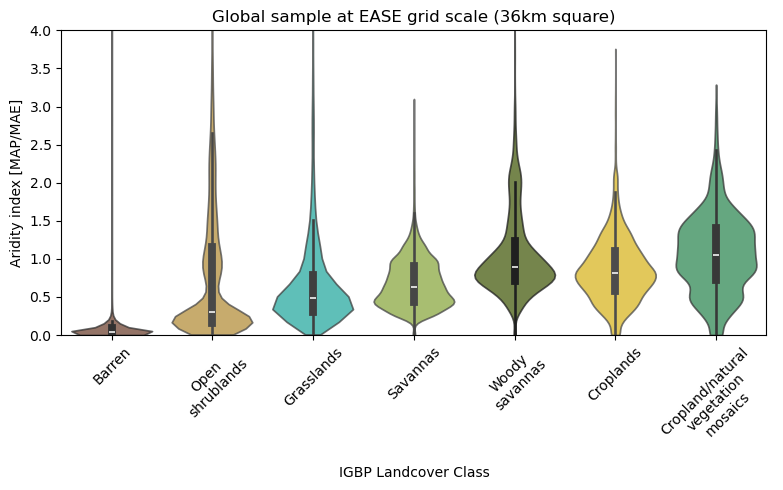

In [59]:
import textwrap
def wrap_at_space(text, max_width):
    parts = text.split(" ")
    wrapped_parts = [wrap(part, max_width) for part in parts]
    return "\n".join([" ".join(wrapped_part) for wrapped_part in wrapped_parts])

fig, ax =  plt.subplots(figsize=(8, 5))
for i, category in enumerate(color_dict.keys()):
    subset = df[df['abbreviation'] == category]
    sns.violinplot(x='name', y='AI', data=subset, color=color_dict[category], ax=ax, alpha=0.75, cut=0)

# ax = sns.violinplot(x='abbreviation', y='q_q', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'), 
max_label_width = 20
ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])
plt.setp(ax.get_xticklabels(), rotation=45)

# ax.set_xticklabels([textwrap.fill(t.get_text(), 10) for t in ax.get_xticklabels()])
ax.set_ylabel("Aridity index [MAP/MAE]")
ax.set_xlabel("IGBP Landcover Class")
ax.set_ylim(0, 4)
ax.set_title("Global sample at EASE grid scale (36km square)")
plt.tight_layout()

# IGBP land_cover and aridity index relationship (where SMAP are sampled)

In [60]:
dir_name = f"raraki_2023-11-25_global_95asmax"

In [61]:
input_file = rf"/home/raraki/waves/projects/smap-drydown/output/{dir_name}/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df_data = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
print(len(df_data))
df_data.head()

588194


,Unnamed: 0,EASE_row_index,EASE_column_index,event_start,event_end,time,sm,min_sm,max_sm,pet,...,exp_r_squared,exp_y_opt,q_k,q_q,q_delta_theta,q_r_squared,q_y_opt,id,latitude,longitude
0,0,6,730,2015-07-07,2015-07-11,[1 2 3 4],[0.30713837 0.28085642 0.24799749 0.22460759],0.088373,0.318546,1.442777,...,0.971327,"[0.30721188076022926, 0.2729472772819034, 0.24...",0.097634,7.248424e-14,1.000000,0.949016,"[0.29607309083610084, 0.27360024792220194, 0.2...",6514,74.71601,92.80083
1,1,6,730,2015-09-04,2015-09-09,[1 2 3 4 5],[0.31340383 0.2997787 0.29239778 0.28315416 0...,0.088373,0.318546,0.564329,...,0.934791,"[0.3143936336489097, 0.30014785762607954, 0.28...",0.042653,4.914108e-15,1.000000,0.937212,"[0.3087283792729129, 0.2989108247958259, 0.289...",6514,74.71601,92.80083
2,2,6,730,2018-08-14,2018-08-28,[ 2 3 4 5 6 7 8 9 10 11 12 13 14],[0.31223514 0.29456268 0.2779323 0.2713341 0...,0.088373,0.318546,0.861008,...,0.578249,"[0.29981222834147464, 0.29402804842083086, 0.2...",0.079208,1.063666e+01,1.000000,0.594935,"[0.29743873412168303, 0.2917893984623552, 0.28...",6514,74.71601,92.80083
3,0,6,731,2015-07-07,2015-07-12,[1 2 3 4 5],[0.29125712 0.26151791 0.22887894 0.23347034 0...,0.086197,0.313482,1.390767,...,0.958683,"[0.2919720832552387, 0.25676322377973104, 0.23...",0.157485,2.233977e+00,1.000000,0.913024,"[0.2830171775741852, 0.26038232314236803, 0.24...",6515,74.71601,93.17427
4,1,6,731,2015-09-04,2015-09-10,[2 3 4 5 6],[0.28169658 0.2896581 0.26309461 0.24856516 0...,0.086197,0.313482,0.578359,...,0.648419,"[0.2860845033697074, 0.2752390328406541, 0.266...",0.067436,2.643255e+00,0.995962,0.652026,"[0.2867481281787417, 0.2764784662039014, 0.267...",6515,74.71601,93.17427


In [62]:
df = df.merge(df_data, on=['EASE_row_index', 'EASE_column_index'], how='left')

/tmp/ipykernel_1309283/3801973456.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])


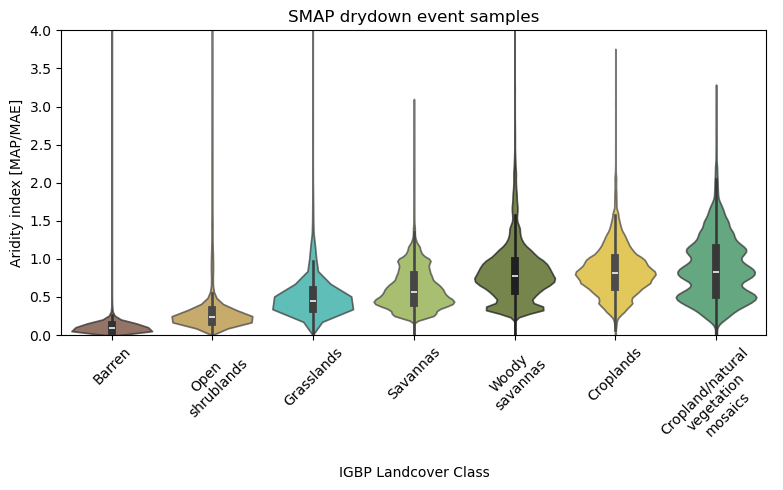

In [64]:
import textwrap
def wrap_at_space(text, max_width):
    parts = text.split(" ")
    wrapped_parts = [wrap(part, max_width) for part in parts]
    return "\n".join([" ".join(wrapped_part) for wrapped_part in wrapped_parts])

fig, ax =  plt.subplots(figsize=(8, 5))
for i, category in enumerate(color_dict.keys()):
    subset = df[df['abbreviation'] == category]
    sns.violinplot(x='name', y='AI', data=subset, color=color_dict[category], ax=ax, alpha=0.75, cut=0)

# ax = sns.violinplot(x='abbreviation', y='q_q', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'), 
max_label_width = 20
ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])
plt.setp(ax.get_xticklabels(), rotation=45)

# ax.set_xticklabels([textwrap.fill(t.get_text(), 10) for t in ax.get_xticklabels()])
ax.set_ylabel("Aridity index [MAP/MAE]")
ax.set_xlabel("IGBP Landcover Class")
ax.set_ylim(0, 4)
ax.set_title("SMAP drydown event samples")
plt.tight_layout()